In [1]:
import numpy as np
import gym
import gym_simple
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Primitive actions
actions = ['move-up', 'move-down', 'move-left', 'move-right', 'move-up-right',
    'move-up-left', 'move-down-right', 'move-down-left', 'pick-up', 'put-down']
# Primitive State description/ Observation:
# Agent position (x,y)
# Ball position (x,y)
# Box position (x,y)
# Agent holding: 0-Nothing, 1-Ball, 2-Box
# Format: [x1,y1,x2,y2,x3,y3,z]

# R-actions
r_actions = ['go-to-ball', 'go-to-box', 'pick-up-ball', 'pick-up-box',
    'put-down-ball', 'put-down-box']
# R-State description
# Agent to Ball distance in steps
# Agent to Box distance in steps
# Agent holding Ball
# Agent holding Box

In [3]:
# Move directions
directions = ['up', 'down', 'left', 'right', 'up-right', 'up-left',
    'down-right', 'down-left']

def move(position, direction):
    """
    Returns a new position after a move in some direction
    """
    x, y = position.values()
    if direction in ['up', 'up-right', 'up-left']:
        x -= 1 # Moves up
    elif direction in ['down', 'down-right', 'down-left']:
        x += 1 # Moves down
    if direction in ['left', 'up-left', 'down-left']:
        y -= 1 # Moves left
    elif direction in ['right', 'up-right', 'down-right']:
        y +=1  # Moves right
    return {'x':x, 'y':y}

def distance_in_moves(position_a, position_b):
    """
    Returns the distance in moves between two positions
    """
    if abs(position_a['x'] - position_b['x']) > \
        abs(position_a['y'] - position_b['y']):
        return abs(position_a['x'] - position_b['x'])
    else:
        return abs(position_a['y'] - position_b['y'])

def go_to(position_a, position_b):
    """
    Returns move action(s) to go from position a to position b
    """
    distance_in_moves_a_b = distance_in_moves(position_a, position_b)
    if position_a == position_b:
        return None
    else:
        # returns move actions that decrease distance between a and b
        return ["move-" + str(direction)
        for direction in directions
            if distance_in_moves(move(position_a, direction),position_b) <
            distance_in_moves_a_b]

In [4]:
# Define (Not) Optimal Policy (Optimal could be: pick up the box first in some
# initial conditions)
# In 4 r-actions:
# Go to ball, pick up ball, go to box, put down ball

def get_optimal_action(observation):
    """
    Returns a primitive action following the optimal Policy
    """
    agent_pos = {'x': observation[0], 'y': observation[1]}
    ball_pos = {'x': observation[2], 'y': observation[3]}
    box_pos = {'x': observation[4], 'y': observation[5]}
    agent_holding_ball = False
    agent_holding_box = False
    if observation[6] == 1:
        agent_holding_ball = True
    elif observation[6] == 2:
        agent_holding_box = True
    # (Not) Optimal Policy
    if distance_in_moves(agent_pos, ball_pos) > 0:
        return np.random.choice(go_to(agent_pos, ball_pos))
    elif distance_in_moves(agent_pos, ball_pos) == 0 and agent_holding_ball is False:
        return 'pick-up'
    elif agent_holding_ball is True and distance_in_moves(agent_pos, box_pos) > 0:
        return np.random.choice(go_to(agent_pos, box_pos))
    elif agent_holding_ball is True and distance_in_moves(agent_pos, box_pos) == 0:
        return 'put-down'

def get_optimal_goal_state(initial_observation):
    """
    Returns the state where the goal is reached in the minimum amount of steps
    """
    agent_pos = {'x': observation[0], 'y': observation[1]}
    ball_pos = {'x': observation[2], 'y': observation[3]}
    box_pos = {'x': observation[4], 'y': observation[5]}
    # The agent will be where the box is initially with the ball there too
    # not holding anything
    return [box_pos,box_pos,box_pos,0]

In [5]:
# Test optimal user-defined policy
env = gym.make('PutBallInBoxEnvRandom8x8-v0')

test_episodes = 10
n_steps = 20

cum_avg_reward_lst = []
total_reward = 0
for i_episode in range(test_episodes):
    print("Episode " + str(i_episode + 1))
    observation,_,_,_ = env.reset()
    for t in range(n_steps):
        env.render()
        action_str = get_optimal_action(observation)
        action = actions.index(action_str)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            print("Reached the goal after {} timesteps".format(t+1))
            break
    cum_avg_reward = total_reward/(i_episode + 1)
    cum_avg_reward_lst.append(cum_avg_reward)
    print(cum_avg_reward)

Episode 1
Reached the goal after 5 timesteps
96.0
Episode 2
Reached the goal after 10 timesteps
93.5
Episode 3
Reached the goal after 12 timesteps
92.0
Episode 4
Reached the goal after 10 timesteps
91.75
Episode 5
Reached the goal after 9 timesteps
91.8
Episode 6
Reached the goal after 10 timesteps
91.66666666666667
Episode 7
Reached the goal after 7 timesteps
92.0
Episode 8
Reached the goal after 8 timesteps
92.125
Episode 9
Reached the goal after 10 timesteps
92.0
Episode 10
Reached the goal after 6 timesteps
92.3


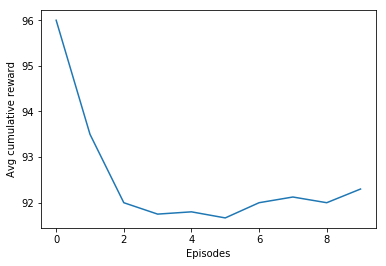

In [6]:
plt.plot(cum_avg_reward_lst)
plt.ylabel('Avg cumulative reward')
plt.xlabel('Episodes')
plt.show()